
# Implementing a CNN in TensorFlow


In [1]:
# Load the required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

tf.compat.v1.disable_eager_execution()

# Load the MNIST dataset
(train, test), info = tfds.load('mnist',split=['train', 'test'], with_info=True, as_supervised=False)

## Defining helper functions

In [3]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()


# Initialize weights using truncated normal distribution
def initialize_weights(shape):
    return tf.compat.v1.Variable(tf.random.truncated_normal(shape, stddev=0.1))


# Initialize biases with a constant value of 0.1
def initialize_bias(shape):
    return tf.compat.v1.Variable(tf.constant(0.1, shape=shape))


# Convolution operation using tf.nn.conv2d
def convolution(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")


# Max pooling operation using tf.nn.max_pool
def max_pooling(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


# Define placeholders for input and output
X_ = tf.compat.v1.placeholder(tf.float32, [None, 784])
X = tf.reshape(X_, [-1, 28, 28, 1])
y = tf.compat.v1.placeholder(tf.float32, [None, 10])

## Defining the convolutional network

In [4]:
# Define the first convolutional layer and pooling layer
W1 = initialize_weights([5, 5, 1, 32])
b1 = initialize_bias([32])
conv1 = tf.nn.relu(convolution(X, W1) + b1)
pool1 = max_pooling(conv1)

# Define the second convolutional layer and pooling layer
W2 = initialize_weights([5, 5, 32, 64])
b2 = initialize_bias([64])
conv2 = tf.nn.relu(convolution(pool1, W2) + b2)
pool2 = max_pooling(conv2)

# Flatten the result of the second pooling layer
flattened = tf.reshape(pool2, [-1, 7 * 7 * 64])

# Define weights and biases for the fully connected layer
W_fc = initialize_weights([7 * 7 * 64, 1024])
b_fc = initialize_bias([1024])
fc_output = tf.nn.relu(tf.matmul(flattened, W_fc) + b_fc)

# Define weights and biases for the output layer
W_out = initialize_weights([1024, 10])
b_out = initialize_bias([10])
YHat = tf.nn.softmax(tf.matmul(fc_output, W_out) + b_out)

## Computing loss

In [5]:
# Compute the cross-entropy loss
cross_entropy = -tf.reduce_sum(y * tf.compat.v1.log(YHat))

# Minimize the loss using Adam optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Calculate the accuracy
predicted_digit = tf.compat.v1.argmax(YHat, 1)
actual_digit = tf.compat.v1.argmax(y, 1)
correct_pred = tf.compat.v1.equal(predicted_digit, actual_digit)
accuracy = tf.compat.v1.reduce_mean(tf.compat.v1.cast(correct_pred, tf.float32))

## Starting the training

In [6]:
# Start a TensorFlow session and initialize all variables
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

batch_size = 100


def preprocess(data):
    image = tf.cast(data["image"], tf.float32) / 255.0
    label = tf.one_hot(data["label"], 10)
    return image, label


train_processed = train.map(preprocess).batch(batch_size)

iterator = tf.compat.v1.data.make_initializable_iterator(train_processed)
next_batch = iterator.get_next()
sess.run(iterator.initializer)

for epoch in range(1000):
    try:

        X_batch, y_batch = sess.run(next_batch)

        X_batch_flattened = X_batch.reshape(-1, 784)
        _, batch_loss, batch_accuracy = sess.run(
            [optimizer, cross_entropy, accuracy],
            feed_dict={X_: X_batch_flattened, y: y_batch},
        )

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {batch_loss}, Accuracy: {batch_accuracy}")
    except tf.errors.OutOfRangeError:
        sess.run(iterator.initializer)

Epoch: 0, Loss: 789.9088745117188, Accuracy: 0.10999999940395355
Epoch: 100, Loss: 36.09505844116211, Accuracy: 0.8700000047683716
Epoch: 200, Loss: 18.81298065185547, Accuracy: 0.9399999976158142
Epoch: 300, Loss: 46.61236572265625, Accuracy: 0.8799999952316284
Epoch: 400, Loss: 15.599380493164062, Accuracy: 0.949999988079071
Epoch: 500, Loss: 11.195846557617188, Accuracy: 0.9599999785423279
Epoch: 700, Loss: 2.5994458198547363, Accuracy: 1.0
Epoch: 800, Loss: 2.4966037273406982, Accuracy: 1.0
Epoch: 900, Loss: 11.385285377502441, Accuracy: 0.949999988079071


## Visualizing extracted features

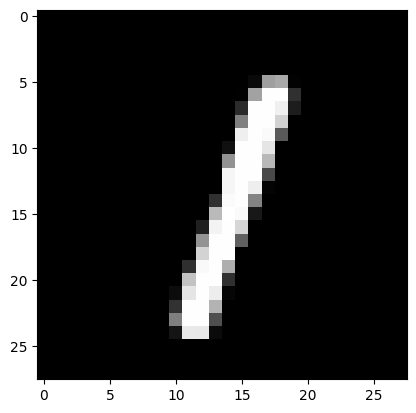

In [7]:
# Create an iterator for the dataset
ds_train_1_batched = train.map(preprocess).batch(1)
iterator = tf.compat.v1.data.make_one_shot_iterator(ds_train_1_batched)

image, label = iterator.get_next()
image_val, label_val = sess.run([image, label])

image, label = iterator.get_next()
image_val, label_val = sess.run([image, label])


plt.imshow(image_val[0, :, :, 0], cmap="gray")
plt.show()

In [8]:
reshaped_image = tf.reshape(image_val, [1, 784])
image_val, label_val = sess.run([reshaped_image, label])

feature_map = sess.run([conv1], feed_dict={X_: image_val})[0]

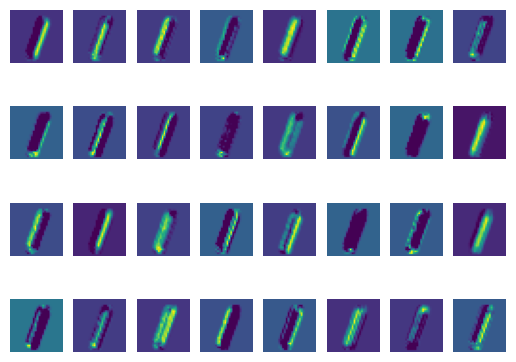

In [9]:
for i in range(32):
    feature = feature_map[:, :, :, i].reshape([28, 28])
    plt.subplot(4, 8, i + 1)
    plt.imshow(feature)
    plt.axis("off")
plt.show()


# Building Capsule networks in TensorFlow

In [10]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Defining the squash function


In [11]:
def squash(sj, epsilon=1e-7):
    sj_norm = tf.reduce_sum(tf.square(sj), -2, keepdims=True)
    scalar_factor = sj_norm / (1 + sj_norm) / tf.sqrt(sj_norm + epsilon)
    vj = scalar_factor * sj
    return vj

## Defining a dynamic routing algorithm

In [12]:
def dynamic_routing(ui, bij, num_routing=10):
    wij = tf.compat.v1.get_variable(
        "Weight",
        shape=(1, 1152, 160, 8, 1),
        dtype=tf.float32,
        initializer=tf.random_normal_initializer(0.01),
    )
    biases = tf.compat.v1.get_variable("bias", shape=(1, 1, 10, 16, 1))
    ui = tf.tile(ui, [1, 1, 160, 1, 1])
    u_hat = tf.reduce_sum(wij * ui, axis=3, keepdims=True)
    u_hat = tf.reshape(u_hat, shape=[-1, 1152, 10, 16, 1])
    u_hat_stopped = tf.stop_gradient(u_hat, name="stop_gradient")

    for r in range(num_routing):
        with tf.compat.v1.variable_scope("iter_" + str(r)):
            cij = tf.nn.softmax(bij, axis=2)
            if r == num_routing - 1:
                sj = tf.multiply(cij, u_hat)
                sj = tf.reduce_sum(sj, axis=1, keepdims=True) + biases
                vj = squash(sj)
            else:
                sj = tf.multiply(cij, u_hat_stopped)
                sj = tf.reduce_sum(sj, axis=1, keepdims=True) + biases
                vj = squash(sj)

                vj_tiled = tf.tile(vj, [1, 1152, 1, 1, 1])
                coupling_coeff = tf.reduce_sum(
                    u_hat_stopped * vj_tiled, axis=3, keepdims=True
                )
                bij += coupling_coeff

    return vj

## Computing primary and digit capsules


In [13]:
import tensorflow as tf
import numpy as np

# Start the TensorFlow Graph
graph = tf.Graph()
with graph.as_default() as g:

    batch_size = 128
    x = tf.compat.v1.placeholder(tf.float32, [batch_size, 784])
    y = tf.compat.v1.placeholder(tf.float32, [batch_size, 10])

    x_image = tf.reshape(x, [-1, 28, 28, 1])

    with tf.name_scope("convolutional_input"):
        input_data = tf.keras.layers.Conv2D(
            filters=256, kernel_size=9, padding="valid"
        )(x_image)

    capsules = []
    for i in range(8):
        with tf.name_scope("capsules_" + str(i)):

            output = tf.keras.layers.Conv2D(
                filters=32, kernel_size=9, strides=2, padding="valid"
            )(input_data)

            output = tf.reshape(output, [batch_size, -1, 1, 1])

            # Store the output (capsule) in the capsules list
            capsules.append(output)

    primary_capsule = tf.concat(capsules, axis=2)

    primary_capsule = squash(primary_capsule)

    with tf.name_scope("dynamic_routing"):

        outputs = tf.reshape(
            primary_capsule, shape=(batch_size, -1, 1, primary_capsule.shape[-2], 1)
        )

        bij = tf.constant(
            np.zeros([1, primary_capsule.shape[1], 10, 1, 1], dtype=np.float32)
        )

        digit_capsules = dynamic_routing(outputs, bij)

    # Squeeze the digit capsules to remove unnecessary dimensions
    digit_capsules = tf.squeeze(digit_capsules, axis=1)

## Masking the digit capsule


In [14]:
with graph.as_default() as g:
    with tf.compat.v1.variable_scope("Masking"):
        masked_v = tf.multiply(tf.squeeze(digit_capsules), tf.reshape(y, (-1, 10, 1)))

## Defining the decoder


In [15]:
with graph.as_default() as g:
    with tf.name_scope("Decoder"):
        v_j = tf.reshape(masked_v, shape=(batch_size, -1))
        fc1 = tf.keras.layers.Dense(units=512, activation="relu")(v_j)
        fc2 = tf.keras.layers.Dense(units=1024, activation="relu")(fc1)
        reconstructed_image = tf.keras.layers.Dense(units=784, activation="sigmoid")(
            fc2
        )

## Computing the accuracy of the model


In [16]:
epsilon = 1e-9
with graph.as_default() as g:
    with tf.compat.v1.variable_scope("accuracy"):
        v_length = tf.sqrt(
            tf.reduce_sum(tf.square(digit_capsules), axis=2, keepdims=True) + epsilon
        )

        softmax_v = tf.nn.softmax(v_length, axis=1)

        argmax_idx = tf.compat.v1.to_int32(tf.argmax(softmax_v, axis=1))
        predicted_digit = tf.reshape(argmax_idx, shape=(batch_size,))

        # Compute the accuracy
        actual_digit = tf.compat.v1.to_int32(tf.argmax(y, axis=1))
        correct_pred = tf.equal(predicted_digit, actual_digit)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Calculating loss


### Margin loss


In [17]:
with graph.as_default() as g:
    with tf.compat.v1.variable_scope("margin_loss"):
        max_left = tf.square(tf.maximum(0.0, 0.9 - v_length))
        max_right = tf.square(tf.maximum(0.0, v_length - 0.1))

        T_k = y
        lambda_ = 0.5

        L_k = T_k * max_left + lambda_ * (1 - T_k) * max_right
        margin_loss = tf.reduce_mean(tf.reduce_sum(L_k, axis=1))

### Reconstruction loss


In [18]:
with graph.as_default() as g:
    with tf.compat.v1.variable_scope("reconstruction_loss"):
        original_image = tf.reshape(x, shape=(batch_size, -1))
        squared = tf.square(reconstructed_image - original_image)
        reconstruction_loss = tf.reduce_mean(squared)

### Total loss


In [19]:
with graph.as_default() as g:
    with tf.compat.v1.variable_scope("total_loss"):
        alpha = 0.0005
        total_loss = margin_loss + alpha * reconstruction_loss
        optimizer = tf.compat.v1.train.AdamOptimizer(0.0001)
        train_op = optimizer.minimize(total_loss)

## Training the Capsule network


In [21]:
num_epochs = 100


# Start the TensorFlow Session and perform training
with tf.compat.v1.Session(graph=graph) as sess:
    (train, test), info = tfds.load(
        "mnist", split=["train", "test"], with_info=True, as_supervised=False
    )

    init_op = tf.compat.v1.global_variables_initializer()
    sess.run(init_op)

    # Create the dataset and iterator within the graph context
    with graph.as_default():
        train_processed = train.map(preprocess).batch(batch_size)
        iterator = tf.compat.v1.data.make_initializable_iterator(train_processed)
        next_batch = iterator.get_next()
        sess.run(iterator.initializer)

    # Training loop
    for epoch in range(num_epochs):
        try:
            batch_data, batch_labels = sess.run(next_batch)
            batch_data = batch_data.reshape(batch_size, 784)
            feed_dict = {x: batch_data, y: batch_labels}

            _, loss, acc = sess.run(
                [train_op, total_loss, accuracy], feed_dict=feed_dict
            )

            if epoch % 10 == 0:
                print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch, loss, acc))
        except tf.errors.OutOfRangeError:
            break
        sess.run(iterator.initializer)

Epoch: 0, Loss: 0.5763105750083923, Accuracy: 0.0859375
Epoch: 10, Loss: 0.5378077626228333, Accuracy: 0.0546875
Epoch: 20, Loss: 0.5323398113250732, Accuracy: 0.1171875
Epoch: 30, Loss: 0.5292855501174927, Accuracy: 0.1015625
Epoch: 40, Loss: 0.52814120054245, Accuracy: 0.125
Epoch: 50, Loss: 0.5272445678710938, Accuracy: 0.1328125
Epoch: 60, Loss: 0.526566207408905, Accuracy: 0.140625
Epoch: 70, Loss: 0.5259942412376404, Accuracy: 0.125
Epoch: 80, Loss: 0.5255122184753418, Accuracy: 0.109375
Epoch: 90, Loss: 0.525112509727478, Accuracy: 0.1171875
